<a href="https://colab.research.google.com/github/TR1234567/Transformer-with-time/blob/main/Draft4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch-forecasting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extens

In [2]:
!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.6 MB/s eta 0:00:00


In [3]:
!pip uninstall yfinance -y

Found existing installation: yfinance 0.2.35
Uninstalling yfinance-0.2.35:
  Successfully uninstalled yfinance-0.2.35


In [ ]:
!pip install yfinance

In [3]:
!pip install onnx


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 32.7 MB/s eta 0:00:00


In [4]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 3.7 MB/s eta 0:00:00


In [5]:
import yfinance
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
from pytorch_forecasting.models.temporal_fusion_transformer.sub_modules import GatedResidualNetwork
import gc
from tqdm.auto import tqdm
import wandb
import math
wandb.init(settings=wandb.Settings(start_method="fork"))



<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Define Model

In [6]:

class Time2Vector(nn.Module):
    def __init__(self, seq_len):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

        # Linear part
        self.linear_weights = nn.Parameter(torch.Tensor(self.seq_len))
        self.linear_bias = nn.Parameter(torch.Tensor(self.seq_len))

        # Periodic part
        self.periodic_weights1 = nn.Parameter(torch.Tensor(self.seq_len))
        self.periodic_bias1 = nn.Parameter(torch.Tensor(self.seq_len))
        self.periodic_weights2 = nn.Parameter(torch.Tensor(self.seq_len))
        self.periodic_bias2 = nn.Parameter(torch.Tensor(self.seq_len))

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.uniform_(self.linear_weights, -0.1, 0.1)
        nn.init.uniform_(self.linear_bias, -0.1, 0.1)
        nn.init.uniform_(self.periodic_weights1, -0.1, 0.1)
        nn.init.uniform_(self.periodic_bias1, -0.1, 0.1)
        nn.init.uniform_(self.periodic_weights2, -0.1, 0.1)
        nn.init.uniform_(self.periodic_bias2, -0.1, 0.1)

    def forward(self, x):
        # Mean reduction across the last dimension
        # x = torch.mean(x, dim=-1)

        # Linear time feature
        print("self.linear_weights ",self.linear_weights.shape )
        print("x" , x.shape)
        print("self.linear_bias", self.linear_bias.shape)
        time_linear = self.linear_weights * x + self.linear_bias
        time_linear = time_linear.unsqueeze(-1)

        # Periodic time features
        time_periodic1 = torch.sin(x * self.periodic_weights1 + self.periodic_bias1)
        time_periodic1 = time_periodic1.unsqueeze(-1)
        time_periodic2 = torch.sin(x * self.periodic_weights2 + self.periodic_bias2)
        time_periodic2 = time_periodic2.unsqueeze(-1)

        # Concatenate linear and periodic features
        return torch.cat([time_periodic1, time_periodic2], dim=-1)


class EncoderLayer(nn.Module):
    """
    model2 = PortfolioTransformer(embed_dim=3027,asset_dim_in=11,asset_dim_out=10,nhead=8,num_model=256,batch_size=1)
    """
    def __init__(self, asset_dim_in, num_model,nhead, dropout=0.1,batch_size=1):  # Add input_dim parameter
        super(EncoderLayer, self).__init__()
        self.embedding = nn.Linear(asset_dim_in+2, num_model) #asset_dim_in = 11, num_model = 256
        self.multihead_attn = nn.MultiheadAttention(num_model, nhead)
        self.grn = GatedResidualNetwork(input_size=num_model,hidden_size=num_model,output_size=num_model)
        # self.grn = GatedResidualNetwork(d_model, dropout, batch_size)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(num_model)

    def forward(self, src, src_mask):
        src = self.embedding(src)
        residual = src
        src,_ = self.multihead_attn(src, src, src, attn_mask=src_mask)
        src = self.dropout(src)
        src = residual + src
        src = self.layer_norm(src)

        residual = src
        src = self.grn(src)
        src = self.dropout(src)
        src = residual + src
        src = self.layer_norm(src)

        return src

class DecoderLayer(nn.Module):
    def __init__(self, num_model, nhead, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.num_model = num_model
        self.masked_mha = nn.MultiheadAttention(num_model, nhead)
        self.encoder_attn = nn.MultiheadAttention(num_model, nhead, dropout=dropout)
        self.grn = GatedResidualNetwork(input_size=num_model,hidden_size=num_model,output_size=num_model)
        # self.dropout = nn.Dropout(dropout)
        self.layer_norm1 = nn.LayerNorm(num_model)
        self.layer_norm2 = nn.LayerNorm(num_model)

    def forward(self, tgt, memory, src_mask, tgt_mask):
        residual = tgt
        # Ensure tgt, memory, src_mask, and tgt_mask have the correct dimensions
        tgt = tgt.view(tgt.size(0), -1, self.num_model) # Reshape tgt to match the shape of memory
        # print("this is tgt shape {}".format(tgt.shape))
        memory = memory.view(memory.size(0), -1, self.num_model)
        # print("this is memory shape {}".format(memory.shape))
        tgt_mask = torch.ones(1,1)

        # Transpose tgt for masked_mha
        tgt = tgt.transpose(0, 1)

        # Masked multi-head attention within decoder
        tgt,_ = self.masked_mha(tgt, tgt, tgt, attn_mask=tgt_mask)
        # tgt = self.dropout(tgt)

        tgt = self.layer_norm1(residual + tgt)

        # Transpose tgt back to original order
        tgt = tgt.transpose(0, 1)
        # print(tgt.shape)
        # Multi-head attention to encoder output

        tgt= self.encoder_attn(tgt, tgt, memory, attn_mask=src_mask)
        # print(tgt[0].shape)
        # print(tgt[1].shape)
        # tgt = self.dropout(tgt)

        tgt = self.layer_norm2(residual + tgt[0])

        # Gated residual network
        tgt = self.grn(tgt)
        # tgt = self.dropout(tgt)
        tgt = self.layer_norm2(tgt + residual)

        return tgt

# class PortfolioLoss(torch.nn.Module):
#     def __init__(self, cost_rate, risk_free_rate=0.1):
#         super(PortfolioLoss, self).__init__()
#         self.cost_rate = cost_rate
#         self.risk_free_rate = risk_free_rate

#     def forward(self, weights, returns):
#         # Ensure weights and returns are in the correct shape
#         # Weights shape: [batch_size, num_assets]
#         # Returns shape: [batch_size, num_assets]


#         # Calculate portfolio returns
#         # Element-wise multiplication and sum over assets for each instance in the batch
#         portfolio_returns = torch.sum(weights * returns, dim=1)
#         print("portfolio_returns",portfolio_returns)
#         # Calculate portfolio volatility (standard deviation of returns)
#         # You may need to adjust this calculation depending on how your returns are structured
#         portfolio_volatility = torch.std(portfolio_returns, dim=0)
#         print("portfolio_volatility",portfolio_volatility)
#         # Calculate transaction costs
#         # Assuming weights are adjacent allocations, calculate the change in weights
#         deltas = torch.abs(weights[1:] - weights[:-1])
#         transaction_costs = self.cost_rate * torch.sum(deltas, dim=1)

#         # Calculate Sharpe Ratio
#         # Note: risk_free_rate is typically a constant like a treasury bond yield
#         sharpe_ratio = (portfolio_returns.mean() - self.risk_free_rate) / portfolio_volatility

#         # Subtract transaction costs
#         sharpe_ratio -= transaction_costs.mean()
#         print("sharpe_ratio : ",sharpe_ratio)
#         # Negate Sharpe Ratio to minimize this value during training
#         cumulative_returns = np.cumprod(1 + returns) - 1
#         peak, trough = np.argmax(np.maximum.accumulate(cumulative_returns) - cumulative_returns), np.argmax(cumulative_returns)
#         max_drawdown = cumulative_returns[peak] - cumulative_returns[trough]
#         average_return = portfolio_returns.mean()
#         print("average_return", average_return)
#         print("max_drawdown",abs(max_drawdown))
#         calmar = average_return / abs(max_drawdown)

#         total_loss = 0.7 * -sharpe_ratio + 0.3 * max_drawdown
#         # return -sharpe_ratio , -calmar , -max_drawdown
#         return -sharpe_ratio

class PortfolioTransformer(nn.Module):
    def __init__(self, embed_dim,asset_dim_in,asset_dim_out,nhead, num_model,batch_size=1):
        super(PortfolioTransformer, self).__init__()
        self.time2vec = Time2Vector(embed_dim)
        self.encoder = EncoderLayer(asset_dim_in=asset_dim_in,num_model=num_model,nhead=nhead,batch_size=batch_size)
        self.decoder = DecoderLayer(num_model=num_model,nhead=nhead)
        self.linear = nn.Linear(num_model, asset_dim_out)
        self.nhead = nhead

    def forward(self, x):
        seq_len = torch.arange(x.shape[0], device=x.device)
        time_features = self.time2vec(seq_len)

        x = torch.cat([x, time_features], dim=-1)

        src_mask = torch.ones(self.nhead, x.shape[0],x.shape[0], dtype=torch.float32)
        # print("X shape ",x.shape,"src_mask shape ",src_mask.shape)

        x = self.encoder(x, src_mask,)

        x = self.decoder(x, x, src_mask, src_mask)
        x = self.linear(x)
        x = x.mean(dim=1)
        # print("This is x before softmax",x)
        weights = torch.nn.functional.softmax(x, dim=-1)
        print("weight of asset shape",weights.shape)
        # print("weight of asset",weights)
        return weights

In [7]:
class PortfolioLoss(torch.nn.Module):
    def __init__(self, cost_rate, risk_free_rate=0.1, window_size=5):
        super(PortfolioLoss, self).__init__()
        self.cost_rate = cost_rate
        self.risk_free_rate = risk_free_rate
        self.window_size = window_size

    def forward(self, weights, returns):
        # Ensure weights and returns are in the correct shape
        # Weights shape: [batch_size, num_assets]
        # Returns shape: [batch_size, num_assets]

        # Rolling window approach for Sharpe Ratio
        num_windows = returns.shape[0] - self.window_size + 1
        sharpe_ratios = []

        for i in range(num_windows):
            window_returns = returns[i:i + self.window_size]
            window_weights = weights[i:i + self.window_size]
            portfolio_returns = torch.sum(window_weights * window_returns, dim=1)
            portfolio_volatility = torch.std(portfolio_returns, dim=0)
            window_sharpe_ratio = (portfolio_returns.mean() - self.risk_free_rate) / portfolio_volatility
            sharpe_ratios.append(window_sharpe_ratio)

        # Average the Sharpe Ratios over all windows
        avg_sharpe_ratio = torch.mean(torch.stack(sharpe_ratios))

        # Calculate transaction costs
        deltas = torch.abs(weights[1:] - weights[:-1])
        transaction_costs = self.cost_rate * torch.sum(deltas, dim=1)

        # Adjusted Sharpe Ratio
        adjusted_sharpe_ratio = avg_sharpe_ratio - transaction_costs.mean()

        # Negate Sharpe Ratio to minimize this value during training
        return -adjusted_sharpe_ratio


# Garch Vol

In [8]:
from arch import arch_model

def rolling_garch_volatility(returns, window_size, model_params=None):
    """
    Calculate rolling GARCH(1,1) volatility estimates for a window of returns.

    :param returns: Array-like, the time series of asset returns.
    :param window_size: Integer, the size of the rolling window to fit the GARCH model.
    :param model_params: Dict or None, pre-fitted model parameters to speed up fitting.
    :return: Numpy array of volatility estimates.
    """
    volatilities = np.zeros_like(returns)
    print(volatilities.shape)

    for i in range(window_size, len(returns)):
        window_returns = returns[i-window_size:i]
        if model_params:
            # Use pre-fitted parameters to initialize the model for faster fitting
            garch = arch_model(window_returns, p=1, q=1, mean='Zero')
            res = garch.fix(model_params)
        else:
            garch = arch_model(window_returns, p=1, q=1, mean='Zero')
            res = garch.fit(disp='off')  # disp='off' turns off the convergence messages

        forecast = res.forecast(horizon=1)
        volatilities[i] = np.sqrt(forecast.variance.values[-1, :])

    # Replace zeros with the first non-zero volatility to avoid issues with early windows
    print(volatilities.shape)
    first_non_zero = next((v for v in volatilities if np.any(v > 0)), volatilities[window_size-1])
    volatilities[:window_size] = first_non_zero

    return torch.tensor(volatilities, dtype=torch.float32)


# Example usage:
# returns = np.array([...])  # Replace with your returns data
# window_size = 252  # Use a 1-year rolling window if you have daily data
# garch_volatilities = rolling_garch_volatility(returns, window_size)
# Now you can use garch_volatilities in your training loop as needed.


In [9]:
class PortfolioLossGARCH(torch.nn.Module):
    def __init__(self, cost_rate, risk_free_rate=0.1, garch_volatility=None):
        super(PortfolioLossGARCH, self).__init__()
        self.cost_rate = cost_rate
        self.risk_free_rate = risk_free_rate
        self.garch_volatility = garch_volatility  # This should be a time-series of volatility forecasts

    def forward(self, weights, returns):
        # Assume garch_volatility is a tensor with the same length as the returns tensor
        # and represents the forecasted volatility for each time step

        # Calculate portfolio returns and volatility as before
        portfolio_returns = torch.sum(weights * returns, dim=1)
        portfolio_volatility = torch.std(portfolio_returns, dim=0)

        # Adjust portfolio volatility by GARCH forecasted volatility
        # This could be a simple multiplication, or a more complex function
        adjusted_volatility = portfolio_volatility * self.garch_volatility

        # Calculate Sharpe Ratio using adjusted volatility
        sharpe_ratio = (portfolio_returns.mean() - self.risk_free_rate) / adjusted_volatility

        # Transaction costs as before
        deltas = torch.abs(weights[1:] - weights[:-1])
        transaction_costs = self.cost_rate * torch.sum(deltas, dim=1)

        # Adjust Sharpe Ratio for transaction costs and negate for minimization
        adjusted_sharpe_ratio = sharpe_ratio - transaction_costs.mean()
        return -adjusted_sharpe_ratio.mean()


# Jump Diffusion

In [62]:
import numpy as np
import torch

def compute_jump_risk_measure(asset_prices, window_size=30, lambda_estimate=0.1):
    """
    Compute an estimated jump risk measure based on the Merton jump-diffusion model.

    :param asset_prices: A torch.Tensor or np.array of asset prices.
    :param window_size: The size of the rolling window to estimate volatility and jump components.
    :param lambda_estimate: The estimated intensity of the Poisson process (number of jumps per time unit).
    :return: A torch.Tensor representing the estimated jump risk measure.
    """
    # Log returns
    # log_returns = torch.log(asset_prices[1:] / asset_prices[:-1])
    # print(log_returns)

    # Rolling window estimation
    jump_risk_measures = []
    for i in range(len(asset_prices) - window_size + 1):
        window = asset_prices[i:i+window_size]

        # Estimate volatility (diffusion component) as the standard deviation of the window
        sigma_est = window.std()
        print("sigma_est",sigma_est)
        # Estimate the jump component as jumps exceeding 3 standard deviations
        jump_component = window[window.abs() > 3 * sigma_est]
        print("jump_component",jump_component)
        # Jump intensity for the window (number of jumps divided by the window size)
        jump_intensity = len(jump_component) / window_size
        print("jump_intensity",jump_intensity)
        # Estimating jump size variance as variance of the jump components
        jump_size_variance = jump_component.var() if len(jump_component) > 1 else torch.tensor(0.0)

        # Combine the estimates to form a jump risk measure
        # Here we use a simple approach: jump intensity times jump size variance
        # More sophisticated methods could be used in practice
        jump_risk_measure = jump_intensity * jump_size_variance
        print("jump_risk_measure",jump_risk_measure)

        jump_risk_measures.append(jump_risk_measure)

    # Return the mean jump risk measure over all windows
    return torch.tensor(jump_risk_measures).mean()



In [12]:
import torch
import torch.nn as nn

# Define your Portfolio Loss class
class PortfolioLossWithJumpRisk(nn.Module):
    def __init__(self, cost_rate, risk_free_rate=0.1):
        super(PortfolioLossWithJumpRisk, self).__init__()
        self.cost_rate = cost_rate
        self.risk_free_rate = risk_free_rate

    def forward(self, weights, returns, jump_risk_measure):
        # Calculate portfolio returns
        portfolio_returns = torch.sum(weights * returns, dim=1)

        # Calculate portfolio volatility
        portfolio_volatility = torch.std(portfolio_returns, dim=0)

        # Adjust volatility for jump risk
        adjusted_volatility = portfolio_volatility * (1 + jump_risk_measure)
        print("adjusted_volatility", adjusted_volatility)

        # Calculate the Sharpe Ratio using adjusted volatility
        sharpe_ratio = (portfolio_returns.mean() - self.risk_free_rate) / adjusted_volatility

        # Compute transaction costs
        deltas = torch.abs(weights[1:] - weights[:-1])
        transaction_costs = self.cost_rate * torch.sum(deltas, dim=1)

        # Adjust Sharpe Ratio for transaction costs
        adjusted_sharpe_ratio = sharpe_ratio - transaction_costs.mean()

        # Return the negative Sharpe Ratio for minimization
        return -adjusted_sharpe_ratio


# Prepare data

In [13]:
Tickers = ["^GSPC", "^IXIC", "^TNX", "^SPGSCI", "^VIX", "VTI"]
Crypto = ["BTC-USD", "ETH-USD", "BNB-USD", "XRP-USD", "USDT-USD"]
start="2012-01-01"
end="2022-12-31"

In [14]:
Stock_df = yfinance.download(Tickers, start=start, end=end, interval="1d")
Crypto_df = yfinance.download(Crypto, start=start, end=end, interval="1d")

[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  5 of 5 completed


In [15]:
def clean_stock(df,col):
    df = df.fillna(0)
    return df[col]
def clean_crypto(df,col):
    df = df.fillna(method='ffill').fillna(method='bfill')
    return df[col]

In [16]:
Stock_df = clean_stock(Stock_df,"Adj Close")
Crypto_df = clean_crypto(Crypto_df,"Adj Close")


In [17]:
Stock_df_pred = yfinance.download(Tickers, start=end,  interval="1d")
Crypto_df_pred = yfinance.download(Crypto, start=end,  interval="1d")

[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  5 of 5 completed


In [18]:
Stock_df_pred = clean_stock(Stock_df_pred,"Adj Close")
Crypto_df_pred = clean_crypto(Crypto_df_pred,"Adj Close")

In [19]:
before = Stock_df[:"2014-09-17"]
after = Stock_df["2014-09-17":]
after_concat = pd.concat([after,Crypto_df],axis=1).fillna(method='bfill')

In [20]:
before

,VTI,^GSPC,^IXIC,^SPGSCI,^TNX,^VIX
Date,,,,,,
2012-01-03,52.435898,1277.060059,2648.719971,666.549988,1.960,22.969999
2012-01-04,52.460026,1277.300049,2648.360107,670.150024,1.995,22.219999
2012-01-05,52.693192,1281.060059,2669.860107,661.320007,1.993,21.480000
2012-01-06,52.572578,1277.810059,2674.219971,661.900024,1.961,20.629999
2012-01-09,52.693192,1280.699951,2676.560059,662.570007,1.960,21.070000
...,...,...,...,...,...,...
2014-09-11,87.649742,1997.449951,4591.810059,588.719971,2.531,12.800000
2014-09-12,87.083702,1985.540039,4567.600098,585.659973,2.614,13.310000
2014-09-15,86.855591,1984.130005,4518.899902,586.299988,2.591,14.120000


In [21]:
after_concat

,VTI,^GSPC,^IXIC,^SPGSCI,^TNX,^VIX,BNB-USD,BTC-USD,ETH-USD,USDT-USD,XRP-USD
Date,,,,,,,,,,,
2014-09-17,87.565269,2001.569946,4562.189941,590.900024,2.600,12.650000,1.990770,457.334015,320.884003,1.008180,0.217488
2014-09-18,88.013000,2011.359985,4593.430176,583.820007,2.629,12.030000,1.990770,424.440002,320.884003,1.008180,0.217488
2014-09-19,87.844048,2010.400024,4579.790039,583.000000,2.587,12.110000,1.990770,394.795990,320.884003,1.008180,0.217488
2014-09-20,87.033020,1994.290039,4527.689941,577.770020,2.566,13.690000,1.990770,408.903992,320.884003,1.008180,0.217488
2014-09-21,87.033020,1994.290039,4527.689941,577.770020,2.566,13.690000,1.990770,398.821014,320.884003,1.008180,0.217488
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,187.638596,3829.250000,10353.230469,610.710022,3.860,21.650000,244.198288,16919.804688,1226.974365,0.999995,0.365723
2022-12-27,187.638596,3829.250000,10353.230469,610.710022,3.860,21.650000,246.596680,16717.173828,1212.791626,0.999850,0.368126
2022-12-28,185.276123,3783.219971,10213.290039,605.900024,3.887,22.139999,244.141922,16552.572266,1189.986084,0.999686,0.356531


In [22]:
test_data = pd.concat([Stock_df_pred,Crypto_df_pred],axis=1).fillna(method='bfill')

In [23]:
mu = before.rolling(1).mean()
mu.drop('^VIX',axis=1,inplace=True)
returns_tensor = torch.tensor(mu.values, dtype=torch.float32)

In [24]:
mu2 = after_concat.rolling(1).mean()
mu2.drop('^VIX',axis=1,inplace=True)
returns_tensor2 = torch.tensor(mu2.values, dtype=torch.float32)

In [25]:
mu_test = test_data.rolling(1).mean()
mu_test.drop('^VIX',axis=1,inplace=True)
returns_tensor_test = torch.tensor(mu_test.values, dtype=torch.float32)[:50]

In [26]:
after_concat_tensor = torch.tensor(after_concat.values, dtype=torch.float32)


In [27]:
test_tensor = torch.tensor(test_data.values, dtype=torch.float32)[:50]


In [28]:
def eda_and_feature_engineering(df):
    # # Calculate log return
    # log_return_df = np.log(df) - np.log(df.shift(1))
    # log_return_df = log_return_df.dropna()

    # Calculate moving average
    moving_average_df = df.rolling(window=20).mean()
    moving_average_df = moving_average_df.dropna()

    # Calculate moving average convergence divergence
    exp1 = df.ewm(span=12, adjust=False).mean()
    exp2 = df.ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    macd = macd.dropna()

    # Calculate relative strength index
    delta = df.diff(1)
    delta = delta.dropna()
    up = delta.copy()
    down = delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    roll_up = up.rolling(window=14).mean()
    roll_down = down.abs().rolling(window=14).mean()
    rs = roll_up / roll_down
    rsi = 100.0 - (100.0 / (1.0 + rs))
    rsi = rsi.dropna()

    # Calculate stochastic oscillator
    low_14, high_14 = df.rolling(window=14).min(), df.rolling
    return moving_average_df, macd,rsi

In [29]:
moving_average_df, macd,rsi = eda_and_feature_engineering(after_concat)

In [30]:
moving_average_df2, macd2,rsi2 = eda_and_feature_engineering(test_data)

In [59]:
final_input = pd.concat([after_concat,moving_average_df,macd,rsi],axis=1).fillna(method='bfill')
final_input

,VTI,^GSPC,^IXIC,^SPGSCI,^TNX,^VIX,BNB-USD,BTC-USD,ETH-USD,USDT-USD,...,^GSPC,^IXIC,^SPGSCI,^TNX,^VIX,BNB-USD,BTC-USD,ETH-USD,USDT-USD,XRP-USD
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-17,87.565269,2001.569946,4562.189941,590.900024,2.600,12.650000,1.990770,457.334015,320.884003,1.008180,...,51.435229,62.725410,87.871868,43.805345,66.666667,0.000000,62.341754,0.000000,0.000000,0.000000
2014-09-18,88.013000,2011.359985,4593.430176,583.820007,2.629,12.030000,1.990770,424.440002,320.884003,1.008180,...,51.435229,62.725410,87.871868,43.805345,66.666667,0.000000,62.341754,0.000000,0.000000,0.000000
2014-09-19,87.844048,2010.400024,4579.790039,583.000000,2.587,12.110000,1.990770,394.795990,320.884003,1.008180,...,51.435229,62.725410,87.871868,43.805345,66.666667,0.000000,62.341754,0.000000,0.000000,0.000000
2014-09-20,87.033020,1994.290039,4527.689941,577.770020,2.566,13.690000,1.990770,408.903992,320.884003,1.008180,...,51.435229,62.725410,87.871868,43.805345,66.666667,0.000000,62.341754,0.000000,0.000000,0.000000
2014-09-21,87.033020,1994.290039,4527.689941,577.770020,2.566,13.690000,1.990770,398.821014,320.884003,1.008180,...,51.435229,62.725410,87.871868,43.805345,66.666667,0.000000,62.341754,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,187.638596,3829.250000,10353.230469,610.710022,3.860,21.650000,244.198288,16919.804688,1226.974365,0.999995,...,29.100050,21.498959,70.771093,70.578490,36.145571,33.417801,45.248727,42.330090,41.275292,40.887265
2022-12-27,187.638596,3829.250000,10353.230469,610.710022,3.860,21.650000,246.596680,16717.173828,1212.791626,0.999850,...,23.319918,14.530453,63.303640,86.262614,45.331951,36.627365,29.877219,30.678024,38.018295,38.126767
2022-12-28,185.276123,3783.219971,10213.290039,605.900024,3.887,22.139999,244.141922,16552.572266,1189.986084,0.999686,...,21.983011,13.939274,52.905115,86.923067,55.733947,37.122873,27.236901,29.454305,22.903176,37.175452


In [32]:
final_test = pd.concat([test_data,moving_average_df2,macd2,rsi2],axis=1).fillna(method='bfill')
final_test

,VTI,^GSPC,^IXIC,^SPGSCI,^TNX,^VIX,BNB-USD,BTC-USD,ETH-USD,USDT-USD,...,^GSPC,^IXIC,^SPGSCI,^TNX,^VIX,BNB-USD,BTC-USD,ETH-USD,USDT-USD,XRP-USD
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-31,187.431885,3824.139893,10386.980469,590.630005,3.793,22.90,246.349197,16547.496094,1196.771240,0.999674,...,79.920380,84.877440,66.045616,30.454563,30.676857,90.853419,99.219494,97.024769,76.392417,81.695466
2023-01-01,187.431885,3824.139893,10386.980469,590.630005,3.793,22.90,244.136978,16625.080078,1200.964844,0.999692,...,79.920380,84.877440,66.045616,30.454563,30.676857,90.853419,99.219494,97.024769,76.392417,81.695466
2023-01-02,187.431885,3824.139893,10386.980469,590.630005,3.793,22.90,245.535904,16688.470703,1214.656616,0.999771,...,79.920380,84.877440,66.045616,30.454563,30.676857,90.853419,99.219494,97.024769,76.392417,81.695466
2023-01-03,187.431885,3824.139893,10386.980469,590.630005,3.793,22.90,246.133362,16679.857422,1214.778809,0.999759,...,79.920380,84.877440,66.045616,30.454563,30.676857,90.853419,99.219494,97.024769,76.392417,81.695466
2023-01-04,189.095459,3852.969971,10458.759766,571.239990,3.709,22.01,259.119690,16863.238281,1256.526611,0.999763,...,79.920380,84.877440,66.045616,30.454563,30.676857,90.853419,99.219494,97.024769,76.392417,81.695466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-18,236.660004,4780.939941,15055.650391,540.640015,4.144,14.13,313.292877,41262.058594,2467.018799,0.999205,...,72.836576,84.974967,54.171445,69.465646,50.000000,43.980758,38.481623,60.636108,18.979476,39.413159
2024-01-19,239.539993,4839.810059,15310.969727,538.830017,4.146,13.30,314.300446,41618.406250,2489.498535,0.999186,...,78.252901,88.528977,46.408451,65.116277,49.473682,48.042994,40.218229,61.589719,19.898143,40.375654
2024-01-20,0.000000,0.000000,0.000000,537.032471,0.000,13.74,316.960388,41665.585938,2469.589111,0.999311,...,2.609328,3.649285,61.029963,5.033712,56.707315,56.236985,40.979022,62.052974,25.819082,45.429963


In [33]:
final_mu = final_input.rolling(1).mean()
final_mu.drop('^VIX',axis=1,inplace=True)
returns_tensor = torch.tensor(final_mu.values, dtype=torch.float32)

In [34]:
mu_test = final_test.rolling(1).mean()
mu_test.drop('^VIX',axis=1,inplace=True)
returns_tensor_test = torch.tensor(mu_test.values, dtype=torch.float32)

In [35]:
mu_test

,VTI,^GSPC,^IXIC,^SPGSCI,^TNX,BNB-USD,BTC-USD,ETH-USD,USDT-USD,XRP-USD,...,VTI,^GSPC,^IXIC,^SPGSCI,^TNX,BNB-USD,BTC-USD,ETH-USD,USDT-USD,XRP-USD
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-31,187.431885,3824.139893,10386.980469,590.630005,3.793,246.349197,16547.496094,1196.771240,0.999674,0.339929,...,82.500051,79.920380,84.877440,66.045616,30.454563,90.853419,99.219494,97.024769,76.392417,81.695466
2023-01-01,187.431885,3824.139893,10386.980469,590.630005,3.793,244.136978,16625.080078,1200.964844,0.999692,0.338763,...,82.500051,79.920380,84.877440,66.045616,30.454563,90.853419,99.219494,97.024769,76.392417,81.695466
2023-01-02,187.431885,3824.139893,10386.980469,590.630005,3.793,245.535904,16688.470703,1214.656616,0.999771,0.348556,...,82.500051,79.920380,84.877440,66.045616,30.454563,90.853419,99.219494,97.024769,76.392417,81.695466
2023-01-03,187.431885,3824.139893,10386.980469,590.630005,3.793,246.133362,16679.857422,1214.778809,0.999759,0.343824,...,82.500051,79.920380,84.877440,66.045616,30.454563,90.853419,99.219494,97.024769,76.392417,81.695466
2023-01-04,189.095459,3852.969971,10458.759766,571.239990,3.709,259.119690,16863.238281,1256.526611,0.999763,0.347794,...,82.500051,79.920380,84.877440,66.045616,30.454563,90.853419,99.219494,97.024769,76.392417,81.695466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-18,236.660004,4780.939941,15055.650391,540.640015,4.144,313.292877,41262.058594,2467.018799,0.999205,0.551907,...,69.200412,72.836576,84.974967,54.171445,69.465646,43.980758,38.481623,60.636108,18.979476,39.413159
2024-01-19,239.539993,4839.810059,15310.969727,538.830017,4.146,314.300446,41618.406250,2489.498535,0.999186,0.544256,...,75.355466,78.252901,88.528977,46.408451,65.116277,48.042994,40.218229,61.589719,19.898143,40.375654
2024-01-20,0.000000,0.000000,0.000000,537.032471,0.000,316.960388,41665.585938,2469.589111,0.999311,0.553126,...,2.495275,2.609328,3.649285,61.029963,5.033712,56.236985,40.979022,62.052974,25.819082,45.429963


# Start Training

In [63]:
config = dict(
    epochs=1,
    embed_dim=15,
    asset_dim_in=44,
    classes=40,
    cost_rate=0.01,
    batch_size=1,
    learning_rate=0.005,
    dataset="Price data",
    architecture="Transformer",
    desc="All data " )

In [37]:
def make(config):

    # Make the model
    model = PortfolioTransformer(embed_dim=config.embed_dim,asset_dim_in=config.asset_dim_in,asset_dim_out=40,nhead=8,num_model=256,batch_size=1)

    # Make the loss and optimizer

    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

    return model, optimizer

In [64]:
from sklearn.preprocessing import StandardScaler
def prepare_input(dataframe):
    # Normalize the data
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(dataframe.values)


    # Convert to tensor
    tensor_data = torch.tensor(normalized_data, dtype=torch.float32)

    return tensor_data

def prepare_output(dataframe):
    # Normalize the data
    mu = dataframe.rolling(1).mean()
    mu.drop('^VIX',axis=1,inplace=True)
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(mu.values)




    # Convert to tensor
    tensor_data = torch.tensor(normalized_data, dtype=torch.float32)

    return tensor_data

In [65]:
import copy

class PortfolioManager:
    def __init__(self, initial_capital, asset_prices):
        self.initial_capital = initial_capital
        self.asset_prices = asset_prices
        self.portfolio = {asset: 0 for asset in asset_prices.columns}
        self.cash = initial_capital
        self.value_over_time = []

    def update_portfolio(self, predicted_weights):
        # Adjust the portfolio based on the predicted weights
        total_value = self.calculate_portfolio_value()
        for asset, weight in predicted_weights.items():
            target_value = total_value * weight
            current_value = self.portfolio[asset] * self.asset_prices[asset].iloc[-1]
            print("update current value",current_value)
            difference = target_value - current_value
            self.buy_sell_asset(asset, difference)

    def buy_sell_asset(self, asset, value):
        # Buy or sell the asset based on the value difference
        if value > 0 and self.cash >= value:
            # Buy asset
            self.portfolio[asset] += value / self.asset_prices[asset].iloc[-1]
            self.cash -= value
        elif value < 0:
            # Sell asset
            sell_amount = min(self.portfolio[asset], -value / self.asset_prices[asset].iloc[-1])
            self.portfolio[asset] -= sell_amount
            self.cash += sell_amount * self.asset_prices[asset].iloc[-1]

    def calculate_portfolio_value(self):
        # Calculate the total value of the portfolio
        total_value = self.cash
        for asset, amount in self.portfolio.items():
            total_value += amount * self.asset_prices[asset].iloc[-1]
        self.value_over_time.append(total_value)
        return total_value

    def summary(self):
        # Summary of the portfolio performance
        initial_value = self.initial_capital
        final_value = self.calculate_portfolio_value()
        return {
            'Initial Capital': initial_value,
            'Final Value': final_value,
            'Performance': (final_value - initial_value) / initial_value
        }


In [66]:
def train(model, df,optimizer, config,portfolio_manager):
    wandb.watch(model, log="all", log_freq=10)

    window_size = config.embed_dim
    prediction_length = config.embed_dim
    total_batches = (len(df) - window_size - prediction_length + 1) * config.epochs
    example_ct = 0
    batch_ct = 0
    print("Start Epoch")

    for epoch in tqdm(range(config.epochs)):
        for start_idx in range(len(df) - window_size - prediction_length + 1):
            print("start index ",start_idx )
            end_idx = start_idx + window_size
            next_end_idx = end_idx + prediction_length
            print("End idx {} : Next end idx", end_idx,next_end_idx )
            input_sequence = df.iloc[start_idx:end_idx]
            target_sequence = df.iloc[end_idx:next_end_idx]

            model_input = prepare_input(input_sequence)
            model_target = prepare_output(target_sequence)
            # garch_volatility = rolling_garch_volatility(model_target,config.embed_dim)
            jump_risk_measure = compute_jump_risk_measure(model_input,window_size=config.embed_dim)

            # loss = train_batch(model_input, model_target, model, optimizer, config.cost_rate,garch_volatility)
            loss = train_batch(model_input, model_target, model, optimizer, config.cost_rate,jump_risk_measure,portfolio_manager)
            example_ct += len(model_input)
            batch_ct += 1

            if ((batch_ct + 1) % 25) == 0:
                train_log(loss, example_ct, epoch)

def train_batch(X, returns_tensor, model, optimizer, cost_rate,jump_risk_measure,portfolio_manager):
    weights = model(X)
    optimizer.zero_grad()
    portfolio_manager.update_portfolio(weights)
    loss = PortfolioLossWithJumpRisk(cost_rate=cost_rate)(weights,returns_tensor,jump_risk_measure)
    # loss = PortfolioLossGARCH(cost_rate=cost_rate,garch_volatility=garch_volatility)(weights, returns_tensor)
    print(loss.shape)
    loss.backward()
    optimizer.step()
    gc.collect()
    print(portfolio_manager.summary())
    return loss

def train_log(loss, example_ct, epoch):
    wandb.log({"epoch": epoch, "loss": loss})
    # print(f"Loss after {str(example_ct).zfill(5)} examples: {loss:.3f}")


In [67]:
def model_pipeline(hyperparameters,portfolio_manager):

    # tell wandb to get started
    with wandb.init(project="Portfolio Transformer", config=hyperparameters):
      # access all HPs through wandb.config, so logging matches execution!
      config = wandb.config

      # make the model, data, and optimization problem
      model, optimizer = make(config)
      # print(model)

      # and use them to train the model
      train(model,final_input,optimizer, config,portfolio_manager)

      # and test its final performance
      test(model, final_test,config,portfolio_manager)

    return model

In [68]:
def test(model, df, config,portfolio_manager):
    wandb.watch(model, log="all", log_freq=10)

    window_size = config.embed_dim
    prediction_length = config.embed_dim
    total_batches = (len(df) - window_size - prediction_length + 1) * config.epochs
    example_ct = 0
    batch_ct = 0
    print("Start Epoch")
    for epoch in tqdm(range(config.epochs)):
        for start_idx in range(len(df) - window_size - prediction_length + 1):
            print("start index ",start_idx )
            end_idx = start_idx + window_size
            next_end_idx = end_idx + prediction_length
            print("End idx {} : Next end idx", end_idx,next_end_idx )
            input_sequence = df.iloc[start_idx:end_idx]
            target_sequence = df.iloc[end_idx:next_end_idx]

            model_input = prepare_input(input_sequence)
            model_target = prepare_output(target_sequence)

            loss = test_model(model, model_input, model_target, config.cost_rate,portfolio_manager)
            example_ct += len(model_input)
            batch_ct += 1

            if ((batch_ct + 1) % 25) == 0:
                train_log(loss, example_ct, epoch)

In [69]:
def test_model(model, Y,returns_tensor_y, cost_rate,portfolio_manager):
    model.eval()

    # Run the model on some test examples
    with torch.no_grad():
        weights = model(Y)
        portfolio_manager.update_portfolio(weights)
        loss= PortfolioLoss(cost_rate=0.01)(weights, returns_tensor_y)
        wandb.log({"test_loss": loss})


    # Save the model in the exchangeable ONNX format
    torch.onnx.export(model, Y, "model.onnx")
    wandb.save("model.onnx")

In [70]:
final_input

,VTI,^GSPC,^IXIC,^SPGSCI,^TNX,^VIX,BNB-USD,BTC-USD,ETH-USD,USDT-USD,...,^GSPC,^IXIC,^SPGSCI,^TNX,^VIX,BNB-USD,BTC-USD,ETH-USD,USDT-USD,XRP-USD
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-17,87.565269,2001.569946,4562.189941,590.900024,2.600,12.650000,1.990770,457.334015,320.884003,1.008180,...,51.435229,62.725410,87.871868,43.805345,66.666667,0.000000,62.341754,0.000000,0.000000,0.000000
2014-09-18,88.013000,2011.359985,4593.430176,583.820007,2.629,12.030000,1.990770,424.440002,320.884003,1.008180,...,51.435229,62.725410,87.871868,43.805345,66.666667,0.000000,62.341754,0.000000,0.000000,0.000000
2014-09-19,87.844048,2010.400024,4579.790039,583.000000,2.587,12.110000,1.990770,394.795990,320.884003,1.008180,...,51.435229,62.725410,87.871868,43.805345,66.666667,0.000000,62.341754,0.000000,0.000000,0.000000
2014-09-20,87.033020,1994.290039,4527.689941,577.770020,2.566,13.690000,1.990770,408.903992,320.884003,1.008180,...,51.435229,62.725410,87.871868,43.805345,66.666667,0.000000,62.341754,0.000000,0.000000,0.000000
2014-09-21,87.033020,1994.290039,4527.689941,577.770020,2.566,13.690000,1.990770,398.821014,320.884003,1.008180,...,51.435229,62.725410,87.871868,43.805345,66.666667,0.000000,62.341754,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,187.638596,3829.250000,10353.230469,610.710022,3.860,21.650000,244.198288,16919.804688,1226.974365,0.999995,...,29.100050,21.498959,70.771093,70.578490,36.145571,33.417801,45.248727,42.330090,41.275292,40.887265
2022-12-27,187.638596,3829.250000,10353.230469,610.710022,3.860,21.650000,246.596680,16717.173828,1212.791626,0.999850,...,23.319918,14.530453,63.303640,86.262614,45.331951,36.627365,29.877219,30.678024,38.018295,38.126767
2022-12-28,185.276123,3783.219971,10213.290039,605.900024,3.887,22.139999,244.141922,16552.572266,1189.986084,0.999686,...,21.983011,13.939274,52.905115,86.923067,55.733947,37.122873,27.236901,29.454305,22.903176,37.175452


In [71]:
initial_capital = 100000  # Example initial capital
asset_prices = final_input.drop('^VIX',axis=1)# Function to load or simulate asset prices

portfolio_manager = PortfolioManager(initial_capital, asset_prices)

In [72]:
model = model_pipeline(config,portfolio_manager)

Start Epoch


  0%|          | 0/1 [00:00<?, ?it/s]

start index  0
End idx {} : Next end idx 15 30
sigma_est tensor(0.5645)
jump_component tensor([ 1.9135,  2.3842,  2.2414,  2.2979,  1.7700,  1.7014,  1.7743, -2.3154,
        -2.3627, -2.3390, -1.7158, -2.4570, -1.8837, -1.9749, -1.8543, -1.9575])
jump_intensity 1.0666666666666667
jump_risk_measure tensor(4.8010)
self.linear_weights  torch.Size([15])
x torch.Size([15])
self.linear_bias torch.Size([15])
weight of asset shape torch.Size([15, 40])


<ipython-input-65-5cea0c0f8608>:37: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  total_value += amount * self.asset_prices[asset].iloc[-1]
Traceback (most recent call last):
  File "<ipython-input-67-c7ca9498e72a>", line 13, in model_pipeline
    train(model,final_input,optimizer, config,portfolio_manager)
  File "<ipython-input-66-69f65162b732>", line 26, in train
    loss = train_batch(model_input, model_target, model, optimizer, config.cost_rate,jump_risk_measure,portfolio_manager)
  File "<ipython-input-66-69f65162b732>", line 36, in train_batch
    portfolio_manager.update_portfolio(weights)
  File "<ipython-input-65-5cea0c0f8608>", line 13, in update_portfolio
    total_value = self.calculate_portfolio_value()
  File "<ipython-input-65-5cea0c0f8608>", line 37, in calculate_portfolio_value
    total_value += amount * self.asset_prices[asset].iloc[-1]
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/generic.py", li

ValueError: cannot reindex on an axis with duplicate labels

# Create Benchmark

In [ ]:
log_data = np.log(after_concat / after_concat.shift(1)).dropna()

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [ ]:
log_data

In [ ]:
scaler = StandardScaler()
# normalized_data = scaler.fit_transform(after_concat)
normalized_data = pd.DataFrame(scaler.fit_transform(after_concat.values), columns=after_concat.columns, index=after_concat.index)


In [ ]:
normalized_data

,VTI,^GSPC,^IXIC,^SPGSCI,^TNX,^VIX,BNB-USD,BTC-USD,ETH-USD,USDT-USD,XRP-USD
Date,,,,,,,,,,,
2014-09-17,-1.182706,-1.155933,-1.148605,1.331474,0.704126,-0.777287,-0.560558,-0.766356,-0.494628,0.741990,-0.588940
2014-09-18,-1.172524,-1.143954,-1.139254,1.266848,0.743633,-0.856648,-0.560558,-0.768388,-0.494628,0.741990,-0.588940
2014-09-19,-1.176366,-1.145129,-1.143337,1.259362,0.686416,-0.846408,-0.560558,-0.770219,-0.494628,0.741990,-0.588940
2014-09-20,-1.194810,-1.164841,-1.158932,1.211623,0.657808,-0.644165,-0.560558,-0.769348,-0.494628,0.741990,-0.588940
2014-09-21,-1.194810,-1.164841,-1.158932,1.211623,0.657808,-0.644165,-0.560558,-0.769971,-0.494628,0.741990,-0.588940
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,1.093019,1.080345,0.584811,1.512301,2.420635,0.374727,0.950922,0.250775,0.398324,-0.740285,-0.130612
2022-12-27,1.093019,1.080345,0.584811,1.512301,2.420635,0.374727,0.965889,0.238255,0.384347,-0.766547,-0.123182
2022-12-28,1.039295,1.024025,0.542923,1.468395,2.457418,0.437448,0.950571,0.228085,0.361872,-0.796242,-0.159033


In [ ]:
returns_daily = normalized_data.pct_change().iloc[1: , :]
returns_daily

,VTI,^GSPC,^IXIC,^SPGSCI,^TNX,^VIX,BNB-USD,BTC-USD,ETH-USD,USDT-USD,XRP-USD
Date,,,,,,,,,,,
2014-09-18,-0.008609,-0.010363,-0.008141,-0.048538,0.056108,0.102100,0.000000,0.002652,0.000000,0.000000,0.000000
2014-09-19,0.003277,0.001027,0.003584,-0.005908,-0.076943,-0.011954,0.000000,0.002384,0.000000,0.000000,0.000000
2014-09-20,0.015678,0.017213,0.013640,-0.037908,-0.041678,-0.238942,0.000000,-0.001132,0.000000,0.000000,0.000000
2014-09-21,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000810,0.000000,0.000000,0.000000
2014-09-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000267,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006984,0.019547,0.020224,-0.012555,-0.313946
2022-12-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015739,-0.049923,-0.035090,0.035476,-0.056884
2022-12-28,-0.049152,-0.052132,-0.071627,-0.029033,0.015195,0.167377,-0.015860,-0.042685,-0.058475,0.038738,0.291037


In [ ]:
returns_daily = normalized_data.pct_change().iloc[1: , :]
returns_annual = returns_daily.mean() * 250
# get daily and covariance of returns of the stock
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 250

# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
stock_weights = []

# set the number of combinations for imaginary portfolios
num_assets = len(normalized_data.columns)
num_portfolios = 50000

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(normalized_data.columns.tolist()):
    portfolio[symbol+' weight'] = [weight[counter] for weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility'] + [stock+' weight' for stock in normalized_data.columns]

# reorder dataframe columns
df = df[column_order]

df.head()

,Returns,Volatility,VTI weight,^GSPC weight,^IXIC weight,^SPGSCI weight,^TNX weight,^VIX weight,BNB-USD weight,BTC-USD weight,ETH-USD weight,USDT-USD weight,XRP-USD weight
0,0.085935,20.050907,0.067765,0.133523,0.093552,0.131197,0.017493,0.022364,0.139649,0.120423,0.068948,0.077919,0.127168
1,0.342090,21.134448,0.041943,0.119350,0.105185,0.008615,0.018622,0.044792,0.152780,0.231083,0.046754,0.107898,0.122978
2,7.615595,60.762967,0.006118,0.061072,0.165774,0.008254,0.045628,0.241893,0.073586,0.070564,0.099952,0.222412,0.004748
3,-6.370239,40.915477,0.185634,0.044686,0.161578,0.073124,0.157331,0.021988,0.178723,0.021618,0.040296,0.087854,0.027166
4,-1.890314,38.891141,0.143164,0.020704,0.145822,0.098764,0.132875,0.087801,0.056492,0.041850,0.084926,0.127401,0.060201


<ipython-input-54-12f3b0c49d86>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


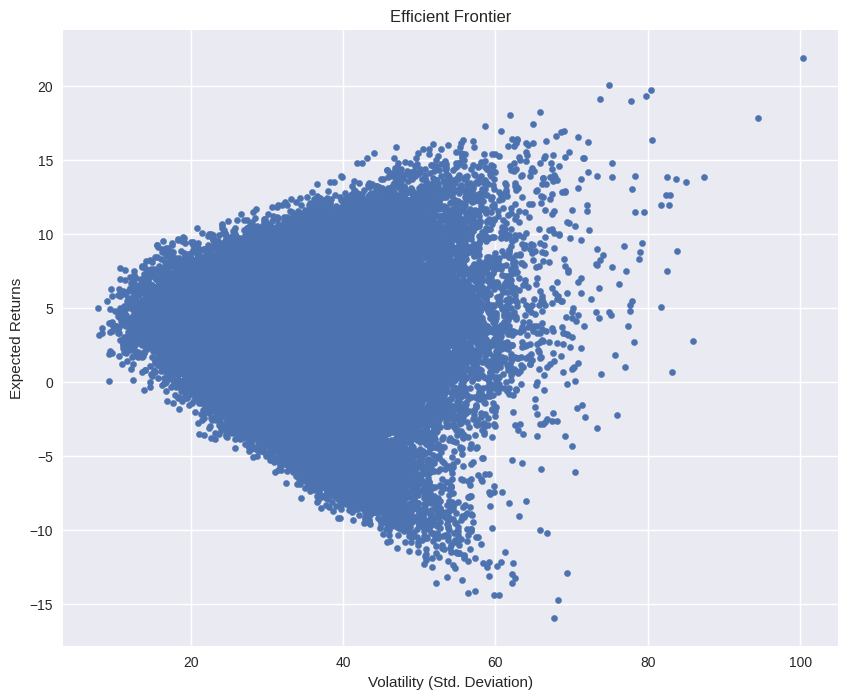

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
df.plot.scatter(x='Volatility', y='Returns', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [ ]:
min_var_port = df.loc[df['Volatility'].idxmin()]

In [ ]:
max_returns = df.loc[df['Returns'].idxmax()]

Text(0.5, 1.0, 'Efficient Frontier and least risky portfolio')

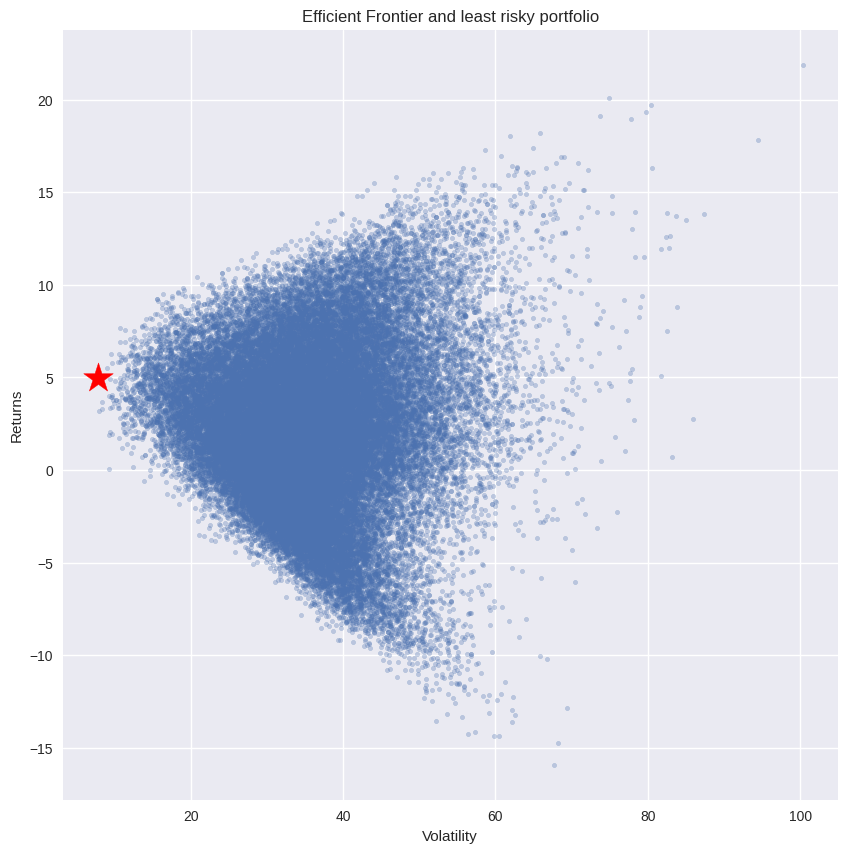

In [ ]:
df.plot.scatter(x='Volatility',y='Returns',grid=True,\
 marker='o', s=10, alpha=0.3,figsize=[10,10])
plt.scatter(x=min_var_port[1],y=min_var_port[0],\
 color='r', marker='*', s=500)
plt.title('Efficient Frontier and least risky portfolio')

Text(0.5, 1.0, 'Efficient Frontier and Most risky portfolio')

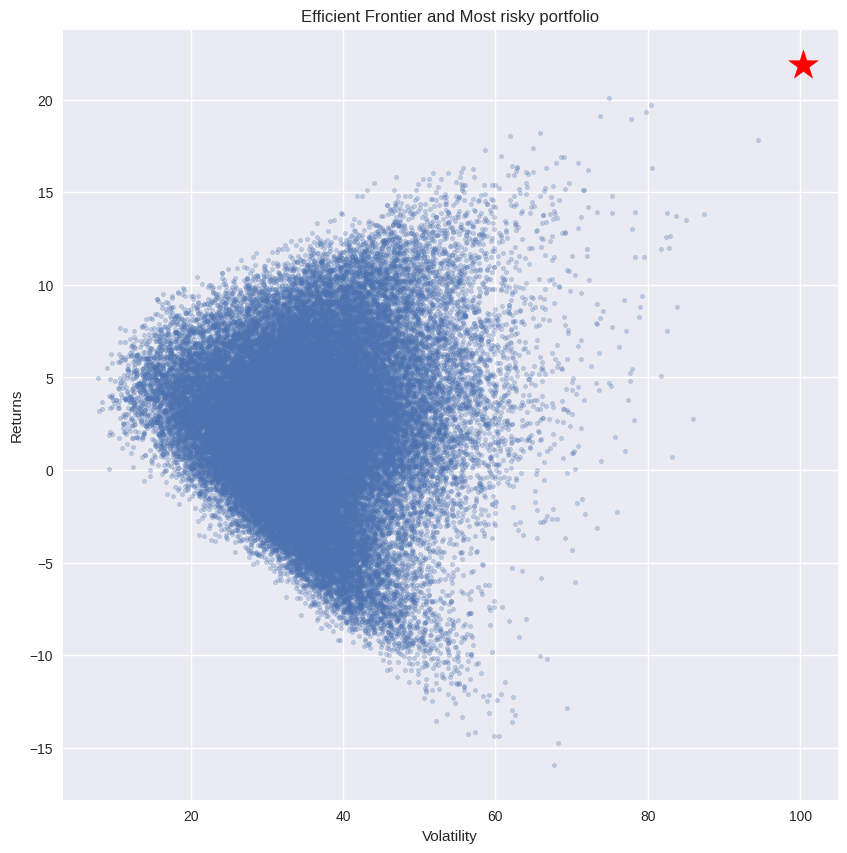

In [ ]:
df.plot.scatter(x='Volatility',y='Returns',grid=True,\
 marker='o', s=10, alpha=0.3,figsize=[10,10])
plt.scatter(x=max_returns[1],y=max_returns[0],\
 color='r', marker='*', s=500)
plt.title('Efficient Frontier and Most risky portfolio')

In [ ]:
window = 20

# Calculate moving average and standard deviation
moving_averages = normalized_data.rolling(window=window).mean()
std_dev = normalized_data.rolling(window=window).std()

# Mean Reversion Strategy
def mean_reversion_strategy(prices, mean, std, std_multiplier=1):
    buy_signal = prices < (mean - std_multiplier * std)
    sell_signal = prices > (mean + std_multiplier * std)
    return buy_signal, sell_signal
Tickers
# Apply strategy
buy_signals, sell_signals = {}, {}
for symbol in Tickers:
    buy_signals[symbol], sell_signals[symbol] = mean_reversion_strategy(normalized_data[symbol], moving_averages[symbol], std_dev[symbol])

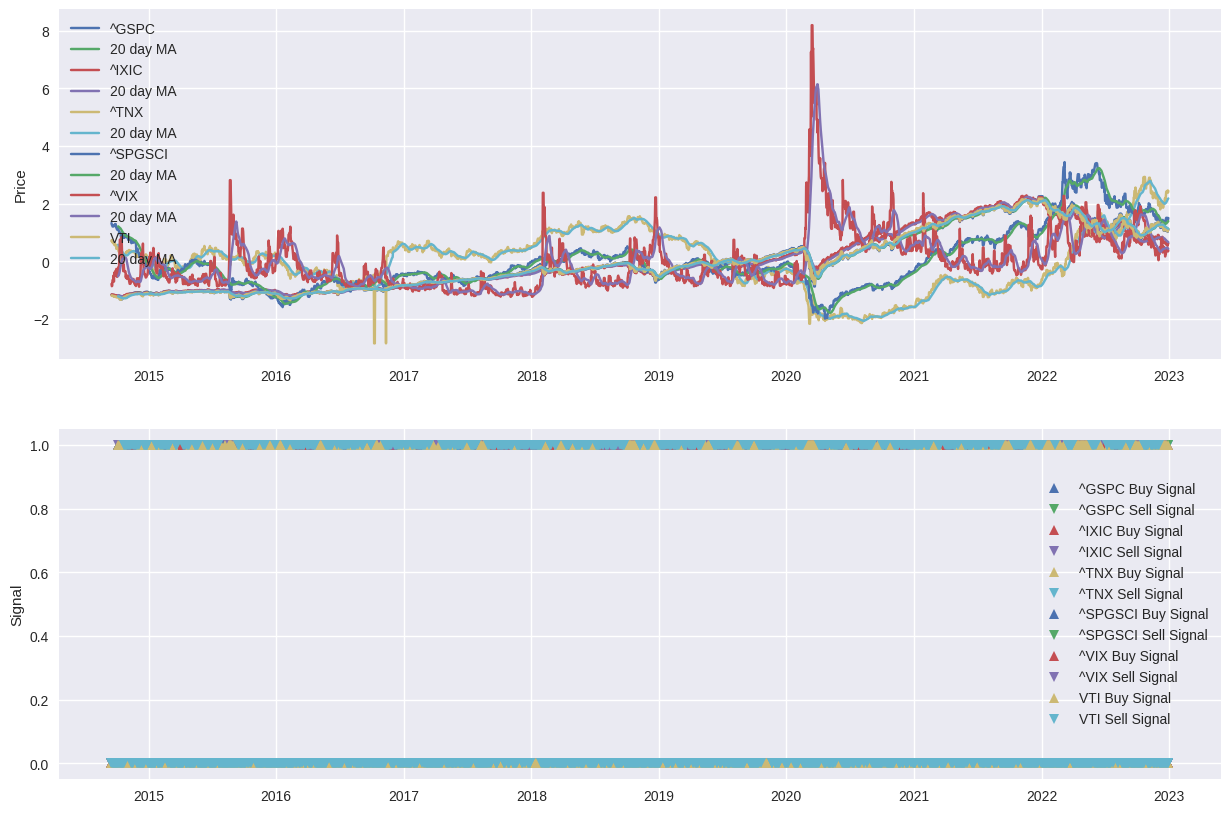

In [ ]:
# Plot the strategy of each stock
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
for symbol in Tickers:
    axes[0].plot(normalized_data[symbol], label=symbol)
    axes[0].plot(moving_averages[symbol], label='{} day MA'.format(window))
    axes[0].set_ylabel('Price')
    axes[0].legend()
    axes[1].plot(buy_signals[symbol], label='{} Buy Signal'.format(symbol), marker='^', linestyle='None')
    axes[1].plot(sell_signals[symbol], label='{} Sell Signal'.format(symbol), marker='v', linestyle='None')
    axes[1].set_ylabel('Signal')
    axes[1].legend()

In [ ]:
def calculate_weights(data):
    returns = data.pct_change().dropna()
    vol = returns.rolling(window=60).std().mean()[:-1]
    inv_vol = 1 / vol
    weights = inv_vol / np.sum(inv_vol)
    return weights * 100  # Convert to percentage

def plot_weights(weights):
    plt.figure(figsize=(12,6))
    weights_sorted = weights.sort_values()
    ax = weights_sorted.plot(kind='barh', color='skyblue')
    plt.title('Risk Parity Weights (%)')
    plt.xlabel('Weights (%)')
    plt.ylabel('Tickers')

    # Adding labels to the bars
    for i, v in enumerate(weights_sorted):
        ax.text(v , i, f"{v:.2f}%", va='center', fontweight='light', fontsize=15)

    plt.tight_layout()
    plt.show()

In [ ]:
weights = calculate_weights(normalized_data)

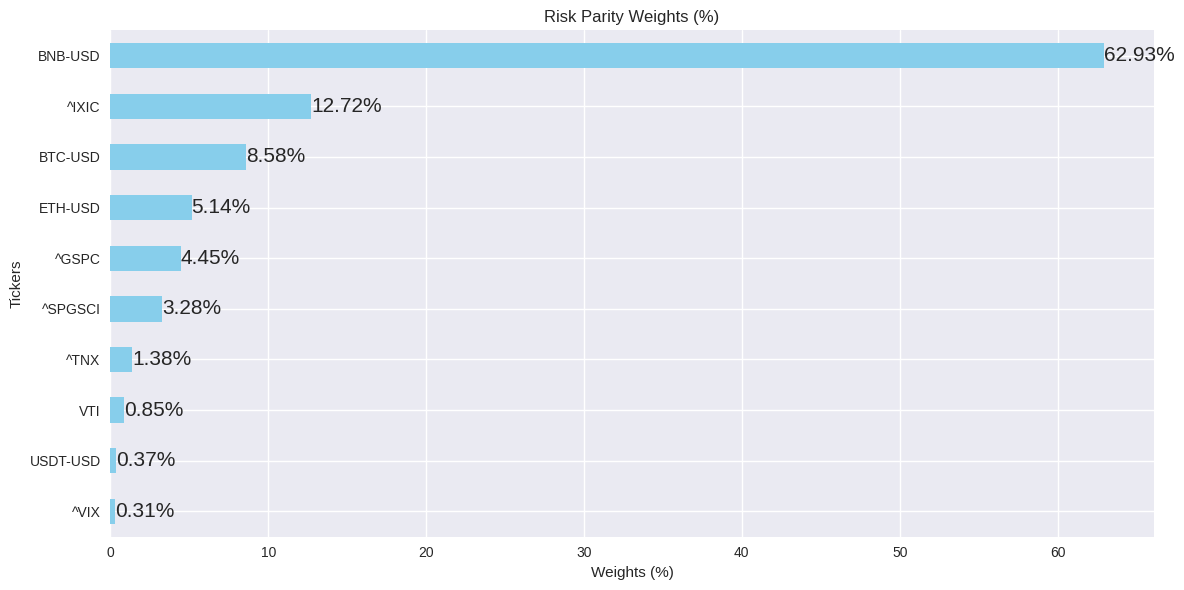

In [ ]:
plot_weights(weights)